In [2]:
%load_ext autoreload
%autoreload 2
from lib.preamble import *

%matplotlib widget
import warnings

# disable divide by zero warning
warnings.filterwarnings("ignore")

In [3]:
# import paths
import csv
def _read_csv(path):
	rows = []
	with open(path) as f:
		r = csv.reader(f)
		for row in r:
			if len(row) == 0:
				return rows
			rows.append(row)
	return rows

def custom_import(path):
	table = _read_csv(path)
	table = np.array(table)[:, :-1]
	table = table.reshape(table.shape[0], table.shape[1]//2, 2).transpose(1, 0, 2)

	measurements = []

	for d in table:
		material = d[0,0]
		measurement = d[1,1]

		wavelength = d[2:,0]
		values = d[2:,1]
		wavelength[wavelength == ''] = np.nan
		values[values == ''] = np.nan
		wavelength = wavelength.astype(float)
		values = values.astype(float)

		# remove nan
		wavelength = wavelength[~np.isnan(wavelength)]
		values = values[~np.isnan(values)]

		if "PS" in material:
			reference = False
		else:
			reference = True

		metadata = extract_metadata(path)
		metadata = {
			**metadata,
			'folder': path.split('/')[-2],
        }

		arr = xr.DataArray(
			data=values,
			coords={'wavelength': wavelength},
			attrs={
				**metadata,
				'material': material,
				'file': path.split('data/')[-1],
				'measurement': measurement,
				'reference': reference,
			},
			name=f"{path.split('data/')[-1]}:\n {measurement} of {material}",
		)
		measurements.append(arr)
	
	measurements = sorted(measurements, key=lambda x: ("PS" not in x.name, x.name))
	
	return measurements

def convert_to_energy(arr: xr.DataArray) -> xr.DataArray:
	"""Converts coord wavelength to energy"""
	arr = arr.copy()
	arr = arr.rename({'wavelength': 'energy'})
	arr['energy'] = 1239 / arr['energy']
	arr['energy'].attrs['units'] = 'eV'
	return arr

paths = glob("../data/2023-11-16/*.csv")
paths += glob("../data/2023-11-17/*.csv")
paths += glob("../data/2023-11-20/*.csv")
paths += glob("../data/2023-11-21/*.csv")
paths += glob("../data/2023-11-22/*.csv")
paths = sorted(paths)

data = list(flatten([custom_import(p) for p in paths]))
for d in data: d.coords['energy'] = 1239 / d.coords['wavelength']

# MnPS3

Fits perfectly with: [vpn](https://journals.aps.org/prb/pdf/10.1103/PhysRevB.44.11060) Fig.1.   
Even the dip in abs in 10K, 2.75eV
on 2023-11-17

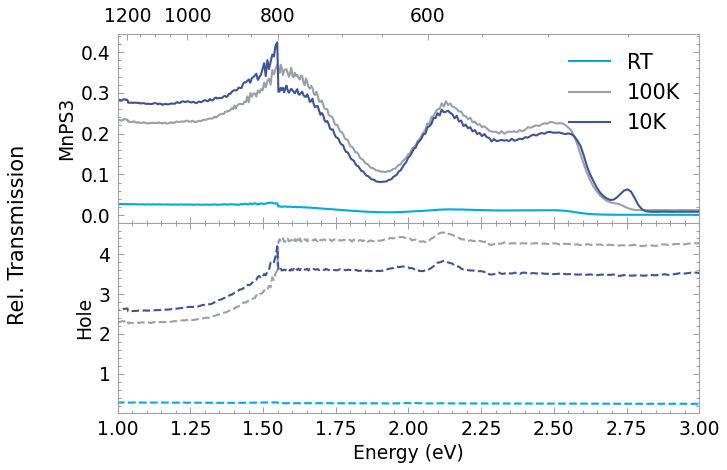

In [3]:
# raw data
sel = [d for d in data if "2023-11-17" in d.name]
# pprint([d.name for d in sel])

def pre(d): return d/100

fig, axs = plt.subplots(2,1, sharex=True)
for d, h, l in zip(
    [d for d in sel if "Mn" in d.name],
    [d for d in sel if "Hole" in d.name],
    ["RT", "100K", "10K"]
    ):
    l = pre(d).plot(label=l, _labels={}, x='energy', ax=axs[0])
    pre(h).plot(_labels={}, x='energy',
        linestyle="dashed", ax=axs[1],
        color=l[0].get_color()
    )

axs[0].legend()
for a in axs: a.set_xlim(1.0, 3)
plot.energy_ticks(ax=axs[0])
plt.xlabel("Energy (eV)")
axs[0].set_ylabel("MnPS3")
axs[1].set_ylabel("Hole")
fig.supylabel("Rel. Transmission", fontsize=FONTSIZE)

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plot.hide_inner_label()
plt.savefig("../report/figures/2024-03-15 MnPS3 transmission raw.pdf")

In [4]:
jump = 800-.1

def correct_jump(d, jump=jump):
    d_copy = d
    below = d.sel(wavelength=slice(None, jump)).isel(wavelength=-1)
    above = d.sel(wavelength=slice(jump, None)).isel(wavelength=0)
    corr = above / below
    d_copy.loc[dict(wavelength=slice(None, jump))] *= corr
    return d_copy

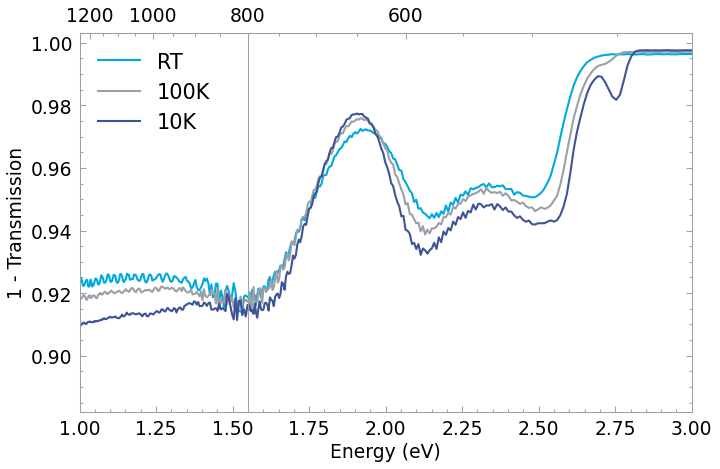

In [10]:
sel = [d for d in data if "2023-11-17" in d.name]
# pprint([d.name for d in sel])


def pre(d, h):
    return 1-(correct_jump(d)/correct_jump(h))

plt.figure()

for d, h, l in zip(
    [d for d in sel if "Mn" in d.name],
    [d for d in sel if "Hole" in d.name],
    ["RT", "100K", "10K"]
    ):
    l = pre(d, h).plot(label=l, _labels={}, x='energy')
    # h.plot(_labels={}, x='energy',
    #     linestyle="dashed",
    #     color=l[0].get_color()
    # )

plt.axvline(ev_to_nm(jump), color=SEEGRAU, lw=.5)

plt.xlim(1.0, 3)
plot.energy_ticks()
plt.xlabel("Energy (eV)")
plt.ylabel("1 - Transmission")
plt.legend()
plt.savefig("../report/figures/2024-03-15 MnPS3 transmission processed.pdf")
plt.show()

'2023-11-08/d005_MnPS_lm_onSample_3x5_532nm_2.58mW.asc'


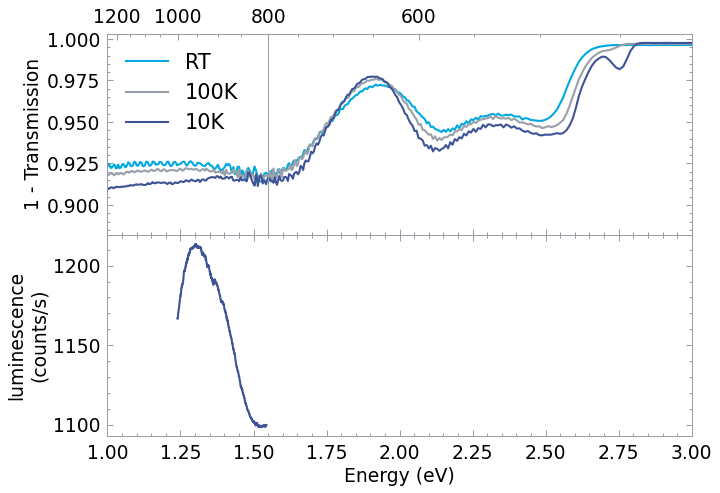

In [6]:
# combined with luminescense
sel = [d for d in data if "2023-11-17" in d.name]
# pprint([d.name for d in sel])


def pre(d, h):
    return 1-(correct_jump(d)/correct_jump(h))

plt.figure()

ax = plt.subplot(2,1,1)

for d, h, l in zip(
    [d for d in sel if "Mn" in d.name],
    [d for d in sel if "Hole" in d.name],
    ["RT", "100K", "10K"]
    ):
    l = pre(d, h).plot(label=l, _labels={}, x='energy')

plt.axvline(ev_to_nm(jump), color=SEEGRAU, lw=.5)

plt.xlim(1.0, 3)
plot.energy_ticks()
plt.ylabel("1 - Transmission")
plt.legend()
# plt.xticks([])


ax = plt.subplot(2,1,2, sharex=ax)
sel_pl = np.load("../selection/2023-12-10 PL.npy", allow_pickle=True)
sel_pl = [d for d in sel_pl if "Mn" in d.name][0]
pprint(sel_pl.name)
sel_pl.rolling(wavelength=100).mean().\
    plot(_labels=False, label="10 K", color="C2", x="energy")
plt.ylabel("luminescence\n(counts/s)")

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plot.hide_inner_label()


plt.xlabel("Energy (eV)")
plt.savefig("../report/figures/2024-03-15 MnPS3 Absorbance with PL.pdf")
plt.show()

# CrPS4, FePS3, NiPS3
Fits on 21.11.2023

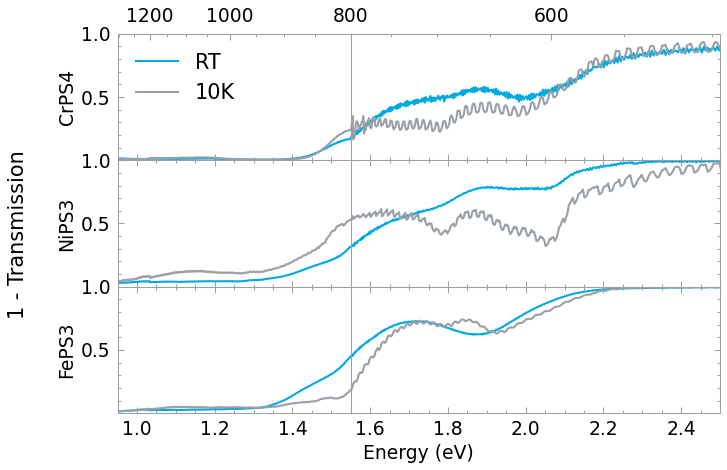

In [13]:
sel = [d for d in data if "2023-11-21" in d.name]
# pprint([d.name for d in sel])

groups = groupby_list(sel, lambda d: d.material)
groups = {
    "CrPS4": groups["CrPS4"],
    "NiPS3": groups["NiPS3"],
    "FePS3": groups["FePS3"],
}

def pre(d, h):
    a = 1-(correct_jump(d)/correct_jump(h))
    a = a-a.min()
    a = a/a.max()
    a = a**2
    return a


fig, axs = plt.subplots(len(groups), 1, sharex=True)

for a, (l, g) in zip(axs, groups.items()):
    for d, h, l in zip(
        [d for d in g],
        [d for d in sel if "Hole" in d.name],
        # ["RT", "10K", "10K SBW", "10K Energy"]
        ["RT", "10K"]
        ):
        pre(d, h).plot(label=l, _labels={}, x='energy', ax=a)
    a.set_ylabel(g[0].material)
    a.axvline(ev_to_nm(jump), color=SEEGRAU, lw=.5)
    a.set_ylim(0.001,1)

plt.xlim(.95, 2.5)
plot.energy_ticks(axs[0])
plt.xlabel("Energy (eV)")
axs[0].legend()
fig.supylabel("1 - Transmission", fontsize=FONTSIZE)
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plot.hide_inner_label()
plt.savefig("../report/figures/2024-03-15 Absorbance.pdf")
plt.show()

MnPS3 doesn't fit the literature.   
But CrPS4 fits with Band gap crossover and insulator-metal transition in the compressed layered CrPS4 Fig.1 b).   
And FePS3 fits with [Spectroscopy and Structural Investigation of Iron Phosphorus Trisulfide—FePS3](https://onlinelibrary.wiley.com/doi/full/10.1002/adom.202102489) Fig.4.   
and NiPS3 fits with [Optical absorption of NiPS3 in the near-infrared,visible and near-ultraviolet regions](https://iopscience.iop.org/article/10.1088/0022-3719/19/36/023/pdf) Fig.1.